The following provides a gentle introduction to `plenoptic`, showing how to create a simple model that works with our synthesis methods, as well 

In [1]:
import plenoptic as po
import torch
import matplotlib.pyplot as plt
import pytest
import pyrtools as pt

%matplotlib inline
%load_ext autoreload
%autoreload 2

To get started, let's create our model (a simple one-channel large Gaussian) and our target image.

In [2]:
im = po.tools.load_images('data/einstein.pgm')

/home/billbrod/miniconda3/envs/synth/lib/python3.8/site-packages/plenoptic/tools/data.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635217151385/work/torch/csrc/utils/tensor_new.cpp:201.)
  images = torch.tensor(images, dtype=torch.float32)


To show how easy it is to construct a plenoptic-compliant model, we're going to go ahead and create the model here. We must define an `__init__` method, which initializes the model, and a `forward` method, which defines how the model transforms its input into its output.

In [3]:
from plenoptic.simulate.canonical_computations import filters
from plenoptic.tools import conv
from torch.nn import functional as F

class Gaussian(torch.nn.Module):
    """Isotropic Gaussian convolutional filter.

    Kernel elements are normalized and sum to one.

    Parameters
    ----------
    kernel_size:
        Size of convolutional kernel.
    """

    def __init__(self, kernel_size):
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size
        # this is a convenience function we provide for creating 2d gaussian
        # filters
        self.filt = filters.circular_gaussian2d(self.kernel_size, 3.)

    def forward(self, x, **conv2d_kwargs):
        # use circular padding so our output is the same size as our input
        x = conv.same_padding(x, self.kernel_size, pad_mode='circular')
        y = F.conv2d(x, self.filt, **conv2d_kwargs)

        return y

In [4]:
model = Gaussian(8)

/home/billbrod/miniconda3/envs/synth/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635217151385/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


To work with out synthesis methods, a model must accept a 4d tensor as input and return a 3d or 4d tensor as output. 4d inputs are commonly used for pytorch models, and the dimensions are batch (often, multiple images), channel (often, RGB or outputs of different convolutional filters), height, and width. The output should then either return a 1d vector or a 2d image per batch and channel. If your model operates across channels or batches, that's no problem; for example if the model transforms RGB to grayscale, your input would have 3 channels and your output would have 1.

We can see below that our `Gaussian` model satisfies this constraint:

In [5]:
print(im.shape)
print(model(im).shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


There's also several slightly more abstract constraints:

- Models must be written in PyTorch, because we make use of the its automatic differentiation features.

- Models must accept real-valued inputs and return real-valued outputs. Anything else makes optimization very tricky.

- Arbitrary model inputs and outputs should have meaning. This is easiest with models that, e.g., operate on images and predict something numeric, such as firing rate. Synthesis will return something that is out-of-set and the only constraint we place on its values is that they fall within some range. If your output is categorical or your input is more abstract, synthesis might not be useful for you

Okay, with those caveats, let's continue.

The following shows the image and the model output. We can see that output is, as we would expect, a blurred version of the input.

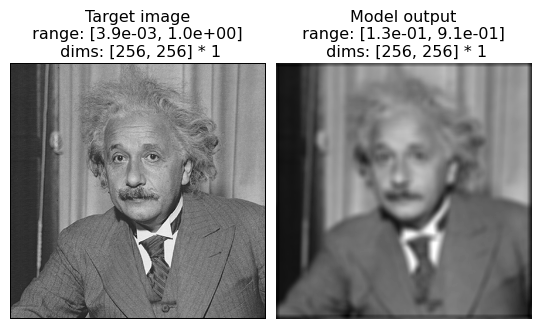

In [6]:
h = model.forward(im)
fig = po.imshow(torch.cat([im, h]), title=['Target image', 'Model output'])

Let's start with metamer synthesis. To initialize, we only need the model and the image (there are some additional options, but the defaults are fine in this case)

In [7]:
met = po.synthesize.Metamer(im, model)

# we do have a default optimizer, with a specific lr and other parameters -- 
# if you want other than the default, create one and pass it to `synthesize`
optim = torch.optim.Adam([met.synthesized_signal], lr=.005)
synth_image = met.synthesize(max_iter=20, optimizer=optim)
# if we call synthesize again, we resume where we left off. 
synth_image = met.synthesize(max_iter=150)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Let's look at the loss over time!

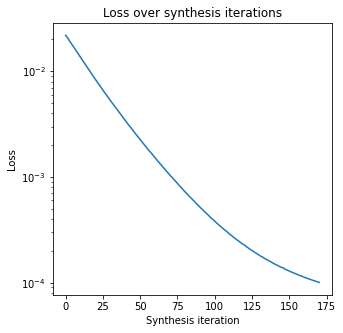

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogy(met.losses)
ax.set(title="Loss over synthesis iterations", ylabel="Loss",
       xlabel="Synthesis iteration");

We can see that the loss is decreasing steadily and has reached a very low value (though it hasn't converged yet).

The following figure compares the target and synthesized images, as well as showing what the model's outputs on these images looks like:

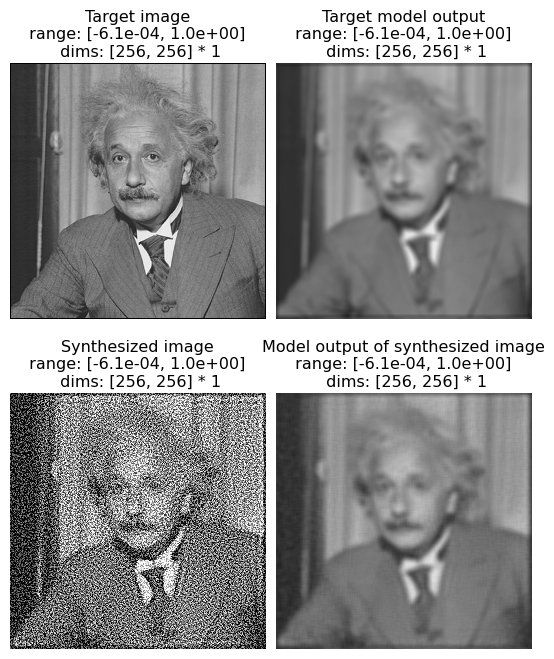

In [9]:
po.imshow(torch.cat([im, h, synth_image, met.model(synth_image)]), col_wrap=2, 
          vrange='auto1',
          title=["Target image", "Target model output", "Synthesized image", 
                 "Model output of synthesized image"]);

We can see that, even though the target and synthesized images look very different, the two model outputs look basically identical (which matches the exceedingly low loss value we see above). (The left column shows the images and the right column the model outputs; top row shows the target and bottom the synthesized.)

It may seem strange that the synthesized image looks like it has high-frequency noise in it -- a Gaussian is a low-pass filter, so why isn't the model metamer just a blurred version of the original image? Indeed, such a blurred image *would* be a model metamer, but it's only one of many. Gaussians are insensitive to high-frequency information, which not only means that their response doesn't change when you remove that information, but that you can *put any amount* of high frequency information into an image without affecting the model's output. Put another way, you can randomize the contents of the model's null space without affecting its response, and the goal of metamer synthesis is to generate different images that do just that.

We can see this more dramatically by initializing our metamer synthesis with a different image. By default, we initialize with a patch of white noise, but we can initialize with any image of the same size. Let's try with  a different natural image, a picture of Marie Curie.

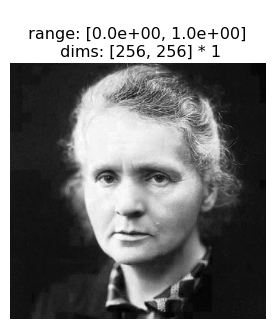

In [10]:
curie = po.load_images('data/curie.pgm')
po.imshow([curie]);

In [11]:
met = po.synthesize.Metamer(im, model, initial_image=curie, )

# we increase the length of time we run synthesis and decrease the
# stop_criterion, which determines when we think loss has converged
# for stopping synthesis early.
optim = torch.optim.Adam([met.synthesized_signal], lr=.005)
synth_image = met.synthesize(max_iter=500, optimizer=optim, stop_criterion=1e-6)

  0%|          | 0/500 [00:00<?, ?it/s]

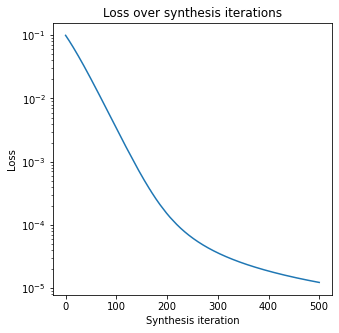

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogy(met.losses)
ax.set(title="Loss over synthesis iterations", ylabel="Loss", 
       xlabel="Synthesis iteration");

We see that the synthesized image looks quite different from the target and from before, while the model outputs look very similar. Here, our synthesized model metamer looks like a blurry picture of Einstein with a high-frequency "shadow" of Curie added on top. Again, this is because the Gaussian model is insensitive to high frequencies, and thus a model metamer can include *any* high frequency information.

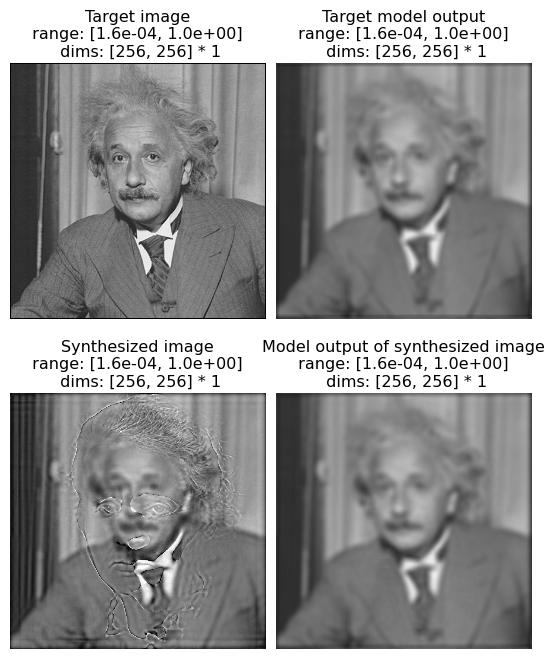

In [13]:
po.imshow(torch.cat([im, h, synth_image, met.model(synth_image)]), col_wrap=2,
          vrange='auto1',
          title=["Target image", "Target model output", "Synthesized image", 
                 "Model output of synthesized image"]);

By generating model metamers, we've gained a better understanding of the information our model is invariant to, but what if we want a better understanding of what our model is *sensitive* to? We can use `Eigendistortion` for that.

Like `Metamer`, `Eigendistortion` accepts an image and a model as its inputs. By default, it synthesizes the top and bottom eigendistortion, that is, the changes to the input image that the model finds most and least noticeable.

In [14]:
eig = po.synthesize.Eigendistortion(im, model)
eig.synthesize();


Initializing Eigendistortion -- Input dim: 65536 | Output dim: 65536


Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/billbrod/miniconda3/envs/synth/lib/python3.8/site-packages/plenoptic/synthesize/eigendistortion.py:356: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635217151385/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  v_new = torch.qr(Fv)[0]  # (ortho)normalize vector(s)


Top k=1 eigendists computed | Tolerance 1.00E-07 reached.


Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Let's examine those distortions:

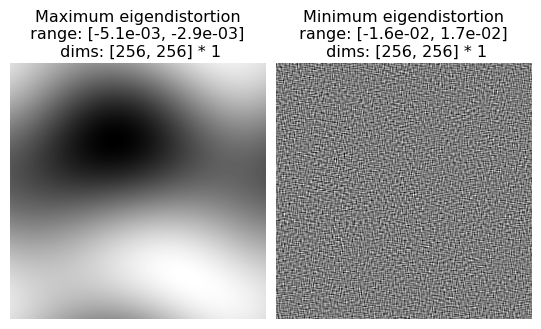

In [15]:
po.imshow(eig.synthesized_signal, title=['Maximum eigendistortion', 
                                         'Minimum eigendistortion']);

We can see they make sense: the most noticeable distortion is a very low-frequency modification to the image, with a period of about half the image. The least noticeable, on the other hand, is very high-frequency, which matches our understanding from the metamer example above.

This brief introduction hopefully demonstrates how you can use `plenoptic` to better understand your model representations! There's much more that can be done with both these methods, as well as two additional methods, `MADCompetition` and `Geodesic`, to explore.